In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_D.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_D'], dtype=object)

In [6]:
data_std.fillna(0, inplace= True)

In [7]:
Y = data_std['Coeff_D'] 
X = data_std.drop(['Coeff_D','Name'], axis=1)

### Using CV technique

RF
R2:  0.9090479883259389
RMSE:  0.3015825122152494
---------------------------------------
GB
R2:  0.8107226203054645
RMSE:  0.43506020237955056
---------------------------------------
LR
R2:  0.006362358103266685
RMSE:  0.996813744837386
---------------------------------------
RR
R2:  0.7479600535936469
RMSE:  0.5020358019169082
---------------------------------------
LASSO
R2:  0.9182201519713367
RMSE:  0.28597176089373466
---------------------------------------
gpr1
R2:  0.9057962329370401
RMSE:  0.3069263218802842
---------------------------------------
gpr2
R2:  0.9321053760592286
RMSE:  0.26056596850082203
---------------------------------------
gpr3
R2:  0.9186282475981375
RMSE:  0.2852573441681431
---------------------------------------
gpr4
R2:  0.9190944354699762
RMSE:  0.28443903482121413
---------------------------------------
gpr5
R2:  0.5677555376438266
RMSE:  0.6574530115195863
---------------------------------------
gpr6
R2:  0.8255255233116643
RMSE:  0.41770142050073

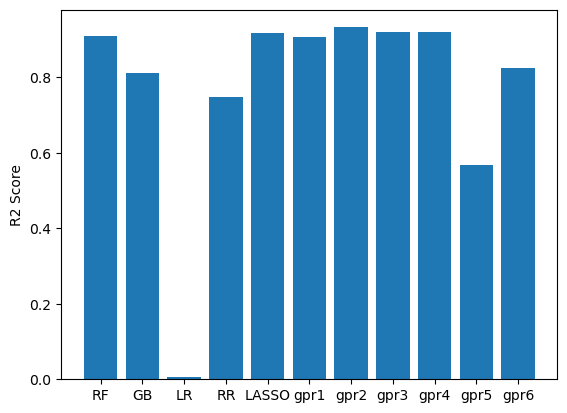

In [8]:
run_models()

## Feature selection


In [9]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
26      X_EA  95.321460
34    X_Rvdw  86.377832
14       X_Z  57.377112
1   mean_A2B  47.599974
17       X_G  42.601054
4   mean_X2X  33.749541
23    X_IEII  29.416755
32    A_Rvdw  27.279924
36      B_Ra  24.281635
30    A_ChiA  23.793760
18     A_IEI  23.778238
2   mean_A2X  21.966084
44      B_Hf  21.103010
13       B_Z  20.453363
11        OF  19.573438
7    std_B2X  16.294713
6    std_A2X  12.148069
24      A_EA  12.141141
35      B_Rc  11.926378
27    A_ChiP  11.798528
9      E_coh  11.712526
49     B_CvM  10.535518
38      B_MP  10.479821
33    B_Rvdw  10.461311
40     B_Rho   9.209004
37      A_MP   9.098591
43      X_MV   7.751609
42      B_MV   7.176187
10        TF   7.108773
5    std_A2B   7.056710


In [10]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'X_IEII',
       'A_Rvdw', 'B_Ra', 'A_ChiA', 'A_IEI', 'mean_A2X', 'B_Hf', 'B_Z',
       'OF', 'std_B2X', 'std_A2X', 'A_EA', 'B_Rc', 'A_ChiP', 'E_coh',
       'B_CvM', 'B_MP', 'B_Rvdw', 'B_Rho', 'A_MP', 'X_MV', 'B_MV', 'TF',
       'std_A2B', 'A_Z', 'A_Kappa', 'std_X2X', 'X_ChiP', 'A_CvM', 'A_B',
       'A_G', 'B_IEII', 'X_Kappa', 'B_B'], dtype=object)

In [11]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9108600444759574
RMSE:  0.29856315165144315
---------------------------------------
GB
R2:  0.7357486286991108
RMSE:  0.5140538603112413
---------------------------------------
LR
R2:  -2.3855606793347524e+20
RMSE:  15445260371.177795
---------------------------------------
RR
R2:  0.23441696003880053
RMSE:  0.8749760225064454
---------------------------------------
LASSO
R2:  0.9212006279612325
RMSE:  0.2807122584405025
---------------------------------------
gpr1
R2:  0.6348492102108595
RMSE:  0.6042770803109617
---------------------------------------
gpr2
R2:  0.9310666100630328
RMSE:  0.26255169002877743
---------------------------------------
gpr3
R2:  0.8837437163597444
RMSE:  0.3409637570772819
---------------------------------------
gpr4
R2:  0.8837437494629823
RMSE:  0.3409637085336469
---------------------------------------
gpr5
R2:  0.9204525321172723
RMSE:  0.2820416066517983
---------------------------------------
gpr6
R2:  0.8462504344224315
RMSE:  0.39210912457

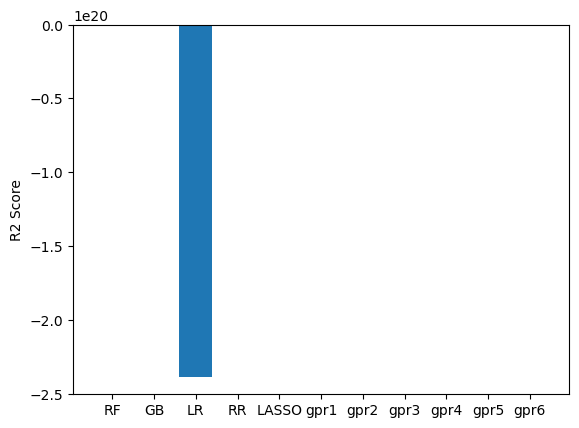

In [12]:
run_models()

In [13]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'X_IEII',
       'A_Rvdw', 'B_Ra', 'A_ChiA', 'A_IEI', 'mean_A2X', 'B_Hf', 'B_Z',
       'OF', 'std_B2X', 'std_A2X', 'A_EA', 'B_Rc', 'A_ChiP', 'E_coh',
       'B_CvM', 'B_MP', 'B_Rvdw', 'B_Rho', 'A_MP', 'X_MV', 'B_MV', 'TF',
       'std_A2B'], dtype=object)

In [14]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9154534410855812
RMSE:  0.29076890981399434
---------------------------------------
GB
R2:  0.7464407706611681
RMSE:  0.5035466506082946
---------------------------------------
LR
R2:  0.6001493545378453
RMSE:  0.6323374458800891
---------------------------------------
RR
R2:  0.6212460708196936
RMSE:  0.6154298734870663
---------------------------------------
LASSO
R2:  0.8854745012760304
RMSE:  0.3384161620312623
---------------------------------------
gpr1
R2:  0.6682892954597147
RMSE:  0.5759433171244244
---------------------------------------
gpr2
R2:  0.9154776219902351
RMSE:  0.2907273258738588
---------------------------------------
gpr3
R2:  0.7797019434735214
RMSE:  0.46935919776486595
---------------------------------------
gpr4
R2:  0.8702260625990159
RMSE:  0.3602414987213219
---------------------------------------
gpr5
R2:  0.9116343251948035
RMSE:  0.29726364528007215
---------------------------------------
gpr6
R2:  0.8637924912857695
RMSE:  0.3690630145574473

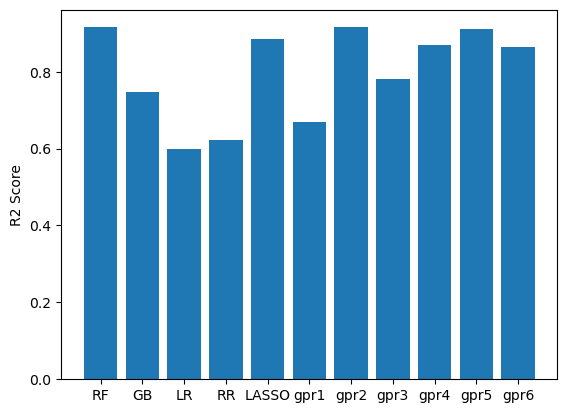

In [15]:
run_models()

In [16]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'X_IEII',
       'A_Rvdw', 'B_Ra', 'A_ChiA', 'A_IEI', 'mean_A2X', 'B_Hf', 'B_Z',
       'OF', 'std_B2X', 'std_A2X', 'A_EA', 'B_Rc', 'A_ChiP'], dtype=object)

In [17]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.893956334105193
RMSE:  0.3256434643821474
---------------------------------------
GB
R2:  0.7863480781968142
RMSE:  0.46222496882274317
---------------------------------------
LR
R2:  0.9113212301295809
RMSE:  0.29778980820440976
---------------------------------------
RR
R2:  0.9115851060895181
RMSE:  0.2973464207124106
---------------------------------------
LASSO
R2:  0.9309862435956442
RMSE:  0.26270469429447935
---------------------------------------
gpr1
R2:  0.9183928564754897
RMSE:  0.2856696405369501
---------------------------------------
gpr2
R2:  0.9281006920187609
RMSE:  0.2681404631554872
---------------------------------------
gpr3
R2:  0.8703764862690428
RMSE:  0.36003265647848837
---------------------------------------
gpr4
R2:  0.8703764993821972
RMSE:  0.3600326382674255
---------------------------------------
gpr5
R2:  0.9212793773563606
RMSE:  0.2805719562672639
---------------------------------------
gpr6
R2:  0.8953758480374298
RMSE:  0.3234565688969235

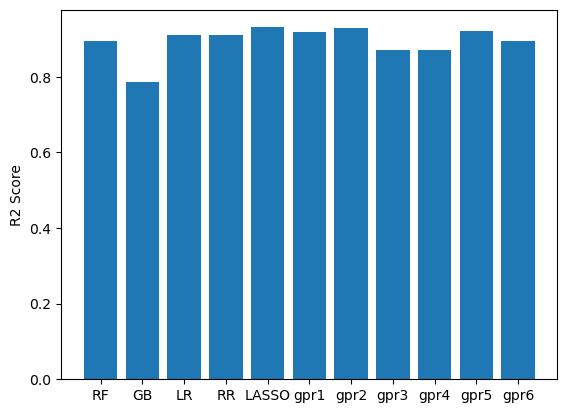

In [18]:
run_models()

In [19]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'X_IEII',
       'A_Rvdw', 'B_Ra', 'A_ChiA'], dtype=object)

In [20]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.907530133475583
RMSE:  0.3040885833509982
---------------------------------------
GB
R2:  0.7080945964906162
RMSE:  0.5402827070241873
---------------------------------------
LR
R2:  0.8879077485786948
RMSE:  0.3348018091667146
---------------------------------------
RR
R2:  0.8879624362950767
RMSE:  0.3347201274272632
---------------------------------------
LASSO
R2:  0.8921206442399855
RMSE:  0.3284499288476319
---------------------------------------
gpr1
R2:  0.8945671624606117
RMSE:  0.3247042308615462
---------------------------------------
gpr2
R2:  0.9293149765966549
RMSE:  0.26586655187019126
---------------------------------------
gpr3
R2:  0.7518418788464054
RMSE:  0.49815471608085227
---------------------------------------
gpr4
R2:  0.7518419722023187
RMSE:  0.4981546223791176
---------------------------------------
gpr5
R2:  0.8959748286648807
RMSE:  0.3225293340691964
---------------------------------------
gpr6
R2:  0.9115365309819098
RMSE:  0.2974280904993512
-

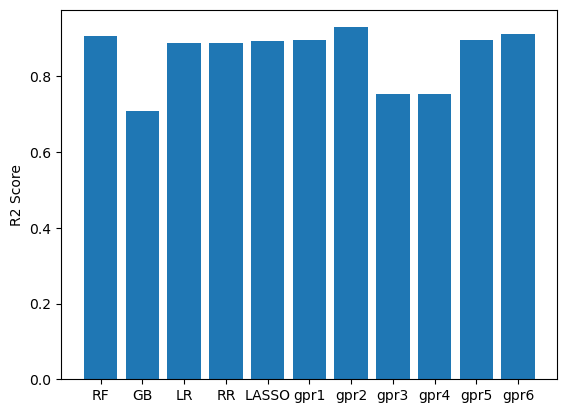

In [21]:
run_models()

# Min-Max scaling

In [22]:
data_mm = pd.read_csv('scaled_minmax_Coeff_D.csv', encoding='cp1252')

In [23]:
data_mm.fillna(0, inplace= True)

In [24]:
Y = data_mm['Coeff_D'] 
X = data_mm.drop(['Coeff_D','Name'], axis=1)

### Using CV technique

RF
R2:  0.9006365113849212
RMSE:  0.07247586531056058
---------------------------------------
GB
R2:  0.7948176940819753
RMSE:  0.10414776317411664
---------------------------------------
LR
R2:  -2.2613416209974195
RMSE:  0.4152198815173667
---------------------------------------
RR
R2:  0.8840205182891984
RMSE:  0.07830158901980341
---------------------------------------
LASSO
R2:  0.7427284926968173
RMSE:  0.11662075244764741
---------------------------------------
gpr1
R2:  0.746120581760951
RMSE:  0.11584938721958449
---------------------------------------
gpr2
R2:  0.9240460992018658
RMSE:  0.06336581648386802
---------------------------------------
gpr3
R2:  0.8956591187862071
RMSE:  0.0742689431346191
---------------------------------------
gpr4
R2:  0.8956591510143319
RMSE:  0.07426893166476699
---------------------------------------
gpr5
R2:  0.9265169160061778
RMSE:  0.06232663515151612
---------------------------------------
gpr6
R2:  0.8649170978522444
RMSE:  0.08450456781

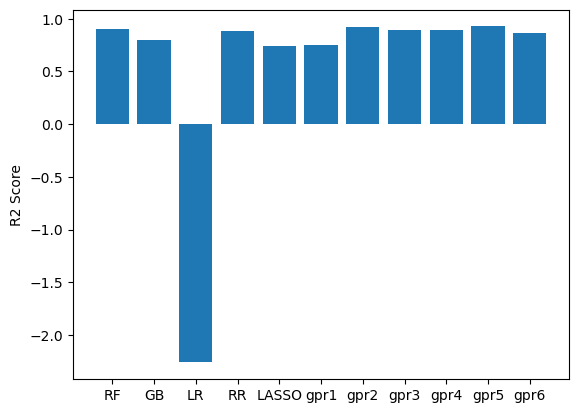

In [25]:
run_models()

## Feature selection


In [26]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
26      X_EA  95.321460
34    X_Rvdw  86.377832
14       X_Z  57.377112
1   mean_A2B  47.599974
17       X_G  42.601054
4   mean_X2X  33.749541
32    A_Rvdw  27.279924
36      B_Ra  24.281635
18     A_IEI  23.778238
30    A_ChiA  23.196933
2   mean_A2X  21.966084
44      B_Hf  21.103010
13       B_Z  20.453363
11        OF  19.573438
7    std_B2X  16.294713
6    std_A2X  12.148069
24      A_EA  12.141141
35      B_Rc  11.926378
27    A_ChiP  11.798528
9      E_coh  11.712526
38      B_MP  10.479821
33    B_Rvdw  10.461311
49     B_CvM  10.060408
31    B_ChiA   9.105932
37      A_MP   9.098591
40     B_Rho   8.712494
43      X_MV   7.751609
42      B_MV   7.176187
10        TF   7.108773
5    std_A2B   7.056710


In [27]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'B_Ra', 'A_IEI', 'A_ChiA', 'mean_A2X', 'B_Hf', 'B_Z', 'OF',
       'std_B2X', 'std_A2X', 'A_EA', 'B_Rc', 'A_ChiP', 'E_coh', 'B_MP',
       'B_Rvdw', 'B_CvM', 'B_ChiA', 'A_MP', 'B_Rho', 'X_MV', 'B_MV', 'TF',
       'std_A2B', 'X_Rho', 'A_Z', 'A_Kappa', 'std_X2X', 'X_ChiP', 'A_CvM',
       'A_B', 'A_G', 'X_IEII', 'B_IEII'], dtype=object)

In [28]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8956476530442187
RMSE:  0.07427302363086138
---------------------------------------
GB
R2:  0.7420019684871673
RMSE:  0.11678530247543677
---------------------------------------
LR
R2:  -1.0170652048234912e+20
RMSE:  2318752483.445911
---------------------------------------
RR
R2:  0.5688681301527148
RMSE:  0.15096805420430925
---------------------------------------
LASSO
R2:  0.742887530903483
RMSE:  0.11658470099611667
---------------------------------------
gpr1
R2:  -0.15027680276218502
RMSE:  0.24659324435012947
---------------------------------------
gpr2
R2:  0.9080501647252432
RMSE:  0.06971969386690564
---------------------------------------
gpr3
R2:  0.8725139714162076
RMSE:  0.0820939759634252
---------------------------------------
gpr4
R2:  0.8725139902333754
RMSE:  0.08209396990481548
---------------------------------------
gpr5
R2:  0.9096558830376482
RMSE:  0.06910825585013525
---------------------------------------
gpr6
R2:  0.8780322232876875
RMSE:  0.080297

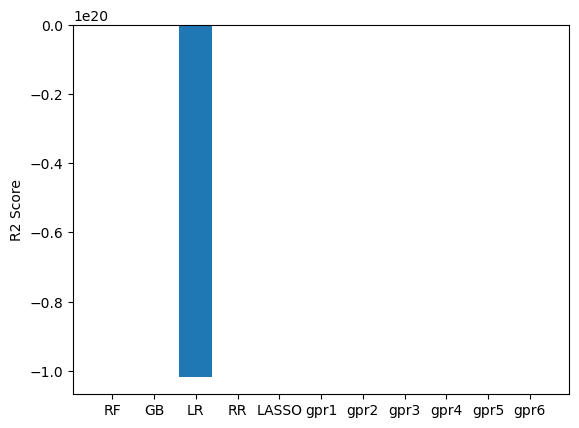

In [29]:
run_models()

In [30]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'B_Ra', 'A_IEI', 'A_ChiA', 'mean_A2X', 'B_Hf', 'B_Z', 'OF',
       'std_B2X', 'std_A2X', 'A_EA', 'B_Rc', 'A_ChiP', 'E_coh', 'B_MP',
       'B_Rvdw', 'B_CvM', 'B_ChiA', 'A_MP', 'B_Rho', 'X_MV', 'B_MV', 'TF',
       'std_A2B'], dtype=object)

In [31]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8975266211460389
RMSE:  0.07360130621994454
---------------------------------------
GB
R2:  0.7582646772412477
RMSE:  0.11304465978429815
---------------------------------------
LR
R2:  0.6374286387627696
RMSE:  0.13844482997107138
---------------------------------------
RR
R2:  0.7773427913155628
RMSE:  0.10849216451879828
---------------------------------------
LASSO
R2:  0.742887530903483
RMSE:  0.11658470099611667
---------------------------------------
gpr1
R2:  0.6500664565486551
RMSE:  0.13601060766861572
---------------------------------------
gpr2
R2:  0.8914838452557493
RMSE:  0.07574032979222195
---------------------------------------
gpr3
R2:  0.6485514807310105
RMSE:  0.13630470671904354
---------------------------------------
gpr4
R2:  0.8864173537915916
RMSE:  0.07748827357032037
---------------------------------------
gpr5
R2:  0.9163984205256945
RMSE:  0.06647942202423437
---------------------------------------
gpr6
R2:  0.8882155249782082
RMSE:  0.0768724529

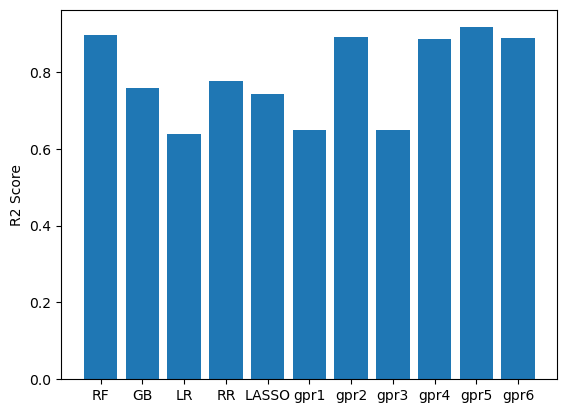

In [32]:
run_models()

In [33]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'B_Ra', 'A_IEI', 'A_ChiA', 'mean_A2X', 'B_Hf', 'B_Z', 'OF',
       'std_B2X', 'std_A2X', 'A_EA', 'B_Rc', 'A_ChiP', 'E_coh'],
      dtype=object)

In [34]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.878683080307713
RMSE:  0.08008306401777768
---------------------------------------
GB
R2:  0.7448143288566429
RMSE:  0.11614703727302497
---------------------------------------
LR
R2:  0.9097901767630356
RMSE:  0.0690568731097963
---------------------------------------
RR
R2:  0.9136415791677792
RMSE:  0.06756664267858675
---------------------------------------
LASSO
R2:  0.744546273395712
RMSE:  0.1162080236045817
---------------------------------------
gpr1
R2:  0.9125652912428504
RMSE:  0.06798638160162802
---------------------------------------
gpr2
R2:  0.9177442276189114
RMSE:  0.06594216262793196
---------------------------------------
gpr3
R2:  0.6069221116387511
RMSE:  0.14415154480558875
---------------------------------------
gpr4
R2:  0.8431394053853404
RMSE:  0.09106194499921726
---------------------------------------
gpr5
R2:  0.9117326999930688
RMSE:  0.06830931256921137
---------------------------------------
gpr6
R2:  0.8998707389905676
RMSE:  0.0727546070102

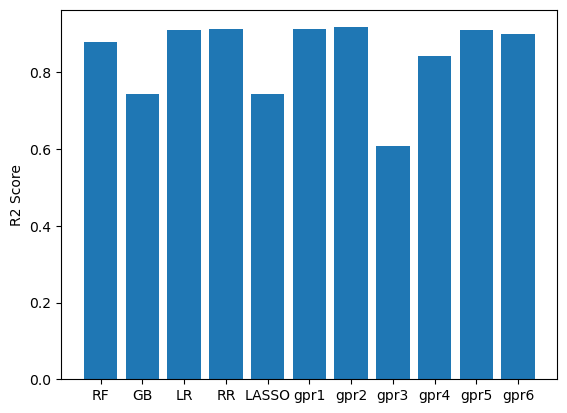

In [35]:
run_models()

In [36]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'B_Ra', 'A_IEI', 'A_ChiA'], dtype=object)

In [37]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.9059756100922438
RMSE:  0.07050180820703414
---------------------------------------
GB
R2:  0.6578077990948688
RMSE:  0.13449775870971717
---------------------------------------
LR
R2:  0.8828308314342744
RMSE:  0.07870216289289851
---------------------------------------
RR
R2:  0.8835313768602537
RMSE:  0.0784665330794563
---------------------------------------
LASSO
R2:  0.7398117963084141
RMSE:  0.11727995620440741
---------------------------------------
gpr1
R2:  0.8831536684918924
RMSE:  0.07859366378492186
---------------------------------------
gpr2
R2:  0.9078825633831306
RMSE:  0.06978320564113932
---------------------------------------
gpr3
R2:  0.6591473134157404
RMSE:  0.13423425426619312
---------------------------------------
gpr4
R2:  0.659147470815629
RMSE:  0.13423422327265846
---------------------------------------
gpr5
R2:  0.8850227528735888
RMSE:  0.07796253406661924
---------------------------------------
gpr6
R2:  0.8970021932421993
RMSE:  0.07378940053

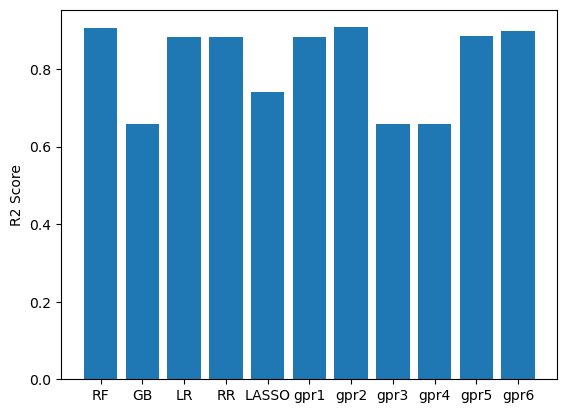

In [38]:
run_models()